In [1]:
# Libraries used in the model are imported here for easy access
import pandas as pd


# Contents

# 1.0 Introduction
 In this project, I take the CRISP-DM (Cross-Industry Standard Process for Data Mining) approach to extract value from business data. The case study is an online retail company registered in the UK with customers from various countries. The raw dataset used for the project is available at the [UCI data repository](https://archive.ics.uci.edu/dataset/352/online+retail).  

The focus of this project is to demonstrate expertise in Data Management and Machine Learning operations. The project includes the establishment of an analytical Dimensional Database model using the star schema. To create more fields for the Database model, the base  dataset from UCI is augmented with generated data using the python faker library. Ultimately, only the original data is queried from the denormalized database and used to create a segmentation and recommendation system for the business.

# 2.0 Business Understanding

Like any typical online business, cross-selling and up-selling to existing customers is a key success factor. From their data records, the company in this case study has thousands of customers. It is inpractical to review their preferences manually and make related recommendations. It is also important for an online retail company to be aware of the habits of their customers so that they can tailor their advertisements and promotions to specific and relevant customer groups. An automated system that understands the customer's behaviour based on previous purchasing decisions will help the company resolve this challenge. The system could also go further to recommend relevant products to the customers. It is best if this recommendation takes place while the customer is still on the website, rather than via email campaigns or subsequent phone calls. The system therefore has to function in real-time.

# 3.0 Data Understanding


The business problem stipulated by the retail company can be resolved by creating a customer segmentation and recommendation system. This will use the customer information and purchase behaviour to group customers. Customers in the same class will be considered to have similar behaviour and thus make similar purchase decisions. The recommendation system will offer recommendations based on the classes.  

Information on the customers will be required to complete this analysis. The data on purchase history including prices, frequency of purchase, and originating country will be retrieved from the company to complete the analysis.

The company maintains a normalized database that is optimized for their transaction processing. A new database will be created that is optimized for analytical processing. It will be a denormalized dimensional model implemented in PostgreSQL.

The original data for the analysis contains the following features. There are no missing values in the data.

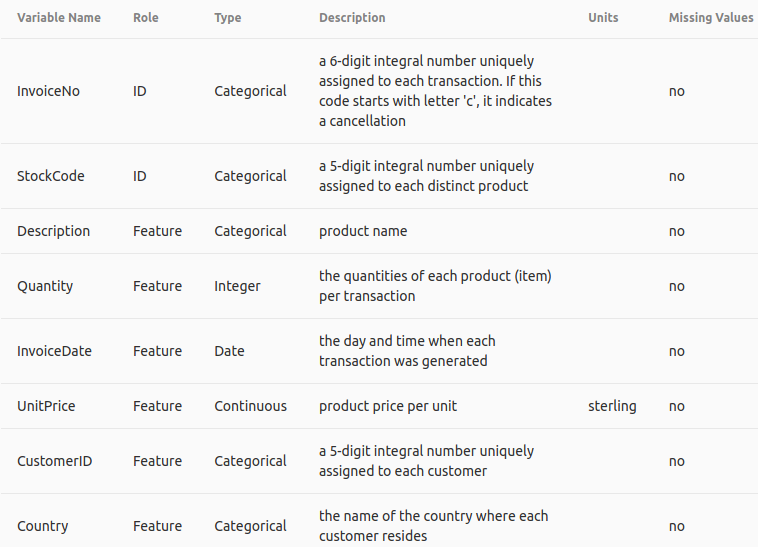  
source: [UCI data repository](https://archive.ics.uci.edu/dataset/352/online+retail)

# 3.1 Dimensional Modeling

Strictly speaking, a dimensional model is not required for this analysis. The required data could simply be extracted from the existing database using a simple SQL statement. A dimensional model will be created to demonstrate prowess.

## 3.1.1 Data Augmentation

In order to create more data fields for the model, a [python script](https://github.com/asoyewole/Datascience-Projects/blob/main/data_generation_script.py) is used to create additional data to augment the customer information from UCI. Additional data including Firstname, Lastname, Address, Phone, Email, and Password were created for all rows in the original dataset. 

In retrospect, creating a password column was unnecessary because user passwords will typically not form part of the data available to analysts. Additionally, handling passwords securely in a database requires encryption (hashing with Bcrypt or scrypt, salting) such that in essence, even the DataBase Administrator has no access to the raw passwords.

None of the 'fake' data will be used in the actual segmentation analysis.

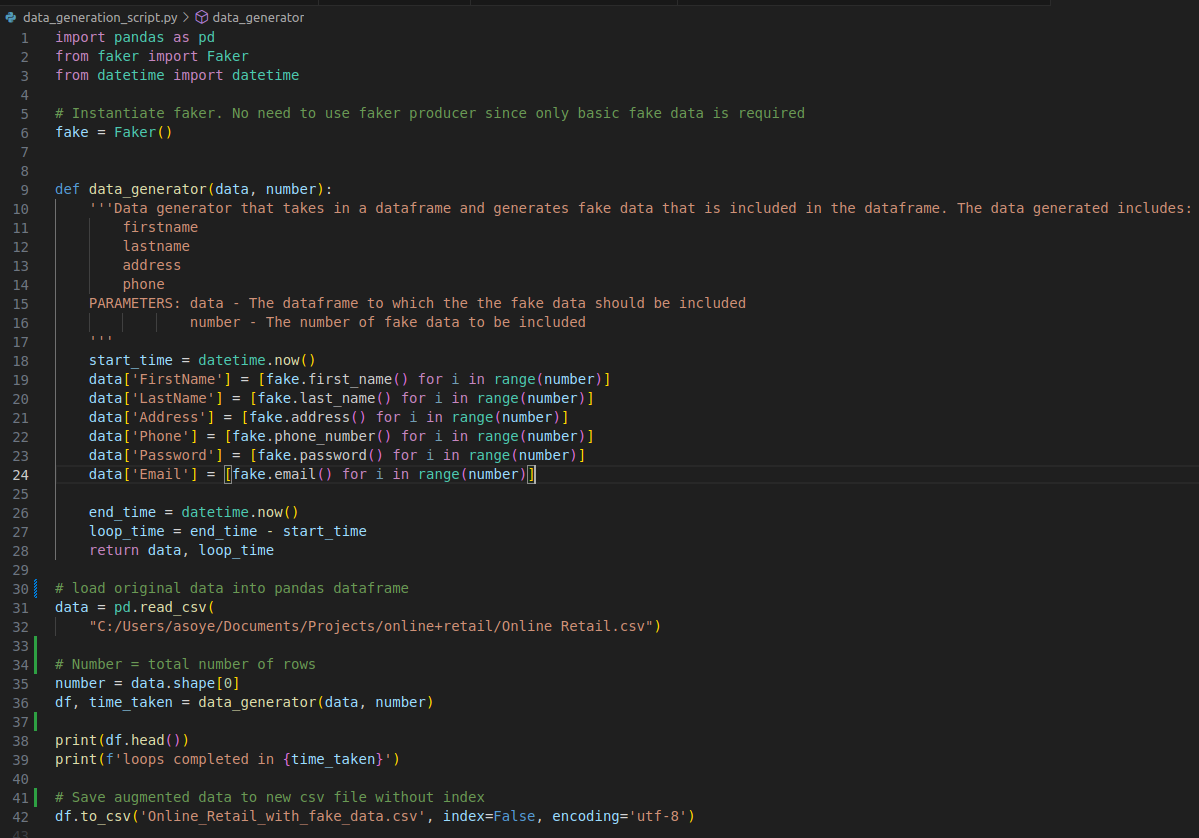  
Data generation script to augment original data with customer information.

## 3.1.2 Conceptual Model

